In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

---
# Classifying handwritten digits

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png)

<br>

<big>

## Load the data

---

- There are 1797 images of handwritten digits of 8x8 pixels each    
- The dataset has 1797 rows and 64 columns
    - Each row is an image, each column is a pixel

<br>

In [3]:
from sklearn import datasets
digits = datasets.load_digits()

print(digits.keys())
print(digits.images.shape)
print(digits.data.shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 8, 8)
(1797, 64)


<br>

<big>

---
## Inspect the data

- An 8x8 pixel image can be displayed using matplotlib's `imshow`

<br>

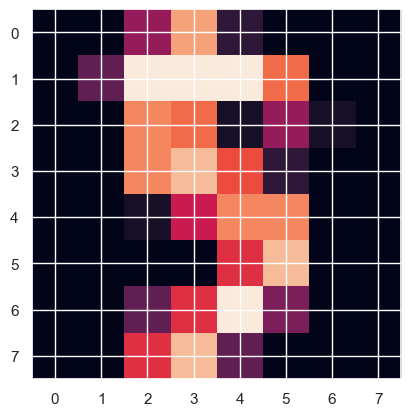

In [4]:
plt.imshow(digits.images[120]);

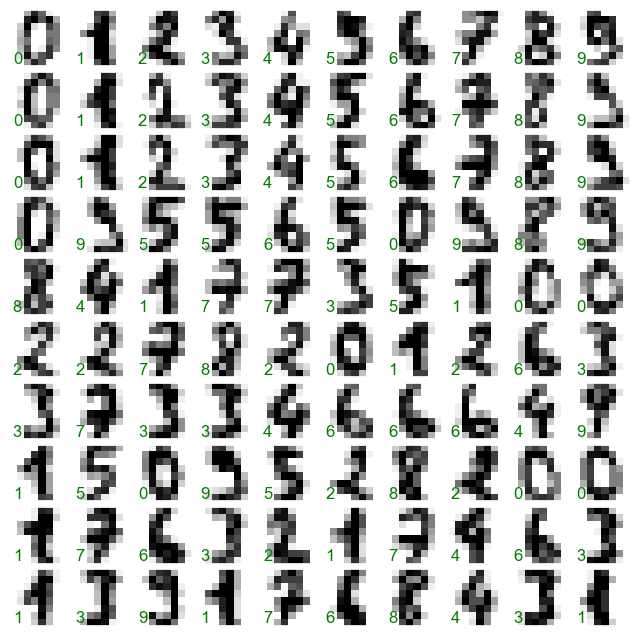

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
digits_df = pd.DataFrame(digits.data, 
                         columns=["Pixel_" + str(i) for i in range(64)])

In [7]:
digits_df[:5]

,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,...,Pixel_54,Pixel_55,Pixel_56,Pixel_57,Pixel_58,Pixel_59,Pixel_60,Pixel_61,Pixel_62,Pixel_63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


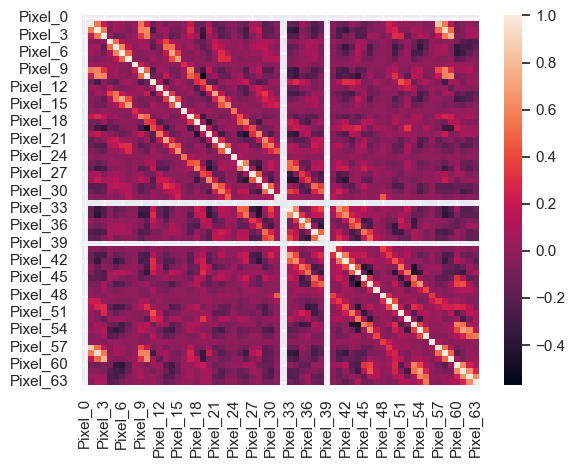

In [8]:
sns.heatmap(digits_df.corr());

<br>

<big>

## Let's build a model

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [10]:
# The Dependent Variable

import numpy as np
np.unique(digits.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<br>

<big>
    
## This is a Multiclass Classification Problem since the Dependent Variable has 10 classes

<br>

## Step 1: Visualize the Classification Boundary using PCA
---

<br>

In [11]:
from sklearn.preprocessing import StandardScaler
X_digits = StandardScaler().fit_transform(digits.data)

In [12]:
from sklearn.decomposition import PCA
pca_2 = PCA(n_components=2)
data_2comp = pca_2.fit_transform(X_digits)

In [14]:
evr = pca_2.explained_variance_ratio_.sum()
print(f"The Explained Variance is: {evr:.1%}")

The Explained Variance is: 21.6%


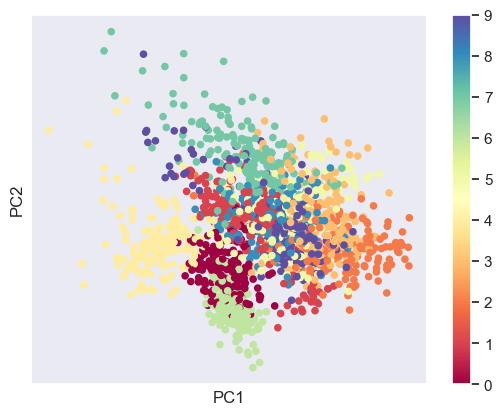

In [22]:
pd.DataFrame(data_2comp, 
          columns=['PC1', 'PC2']).plot.scatter(x='PC1', y='PC2', 
                                               c=digits.target, cmap='Spectral', 
                                               xticks=[], yticks=[]);

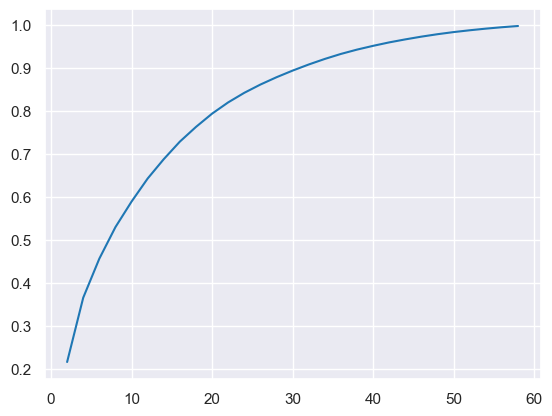

In [25]:
pd.Series({n:PCA(n_components=n).fit(X_digits).explained_variance_ratio_.sum() for n in range(2, 60, 2)}, name='Explained Variance').plot();

In [26]:
# Selecting the 25 component solution that explains 85% of the variance.

X_pca = PCA(n_components=25).fit_transform(X_digits)

In [ ]:
pd.DataFrame(X_pca)

---

## Dimensionality Reduction with `Isomap`

- We'd like to visualize our points within the **64-dimensional parameter space**, but it's difficult to plot points in 64 dimensions!

- Instead we'll reduce the dimensions to 2, using an unsupervised method.

- Here, we'll make use of a **manifold learning algorithm** called *Isomap*, and transform the data to two dimensions.

- This is a critical step because it will lead to the selection of a few candidate algorithms that would possess the ability to discover the classfication boundary for this data.

In [28]:
from sklearn.manifold import Isomap, TSNE

In [30]:
iso = Isomap(n_components=2, n_neighbors=10)
data_projected = iso.fit_transform(digits.data)
data_projected.shape

(1797, 2)

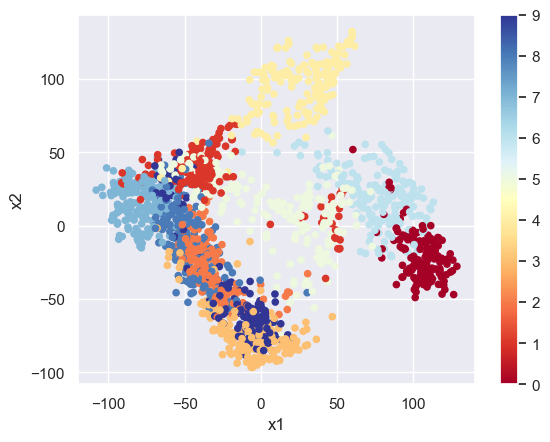

In [31]:
# Visualize the data in 2 dimensions

(pd.DataFrame(data_projected, columns=['x1', 'x2'])
 .plot
 .scatter(x='x1', y='x2', 
          c=digits.target, 
          cmap='RdYlBu'));

In [33]:
tsne = TSNE(n_components=2)
data_projected = tsne.fit_transform(digits.data)
data_projected.shape

(1797, 2)

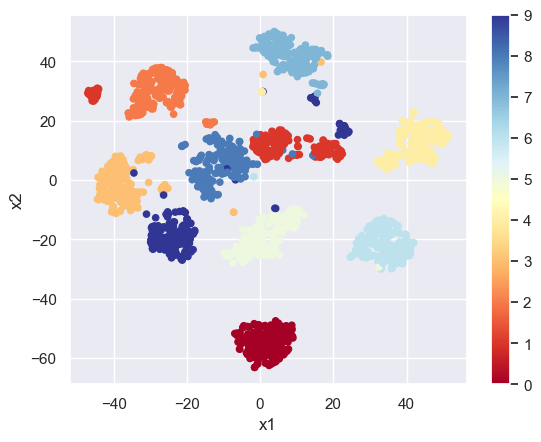

In [34]:
# Visualize the data in 2 dimensions

(pd.DataFrame(data_projected, columns=['x1', 'x2'])
 .plot
 .scatter(x='x1', y='x2', 
          c=digits.target, 
          cmap='RdYlBu'));

<br>

<big>

We see here that the digits are fairly well-separated in the parameter space; this tells us that a supervised classification algorithm should perform fairly well. 
Let's give it a try.

---

In [35]:
# Data Splitting
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(digits.data, 
                                                digits.target, 
                                                random_state=2)

In [36]:
round(Xtrain.shape[0]/1797.0, 2)

0.75

---
### `Logistic Regression` with Default Hyperparameters

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(digits.data, digits.target, train_size=0.8)

clf = LogisticRegression(max_iter=300)
clf.fit(Xtrain, Ytrain)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [88]:
# Training Accuracy
round(accuracy_score(Ytrain, clf.predict(Xtrain)), 3)

1.0

In [89]:
# Test Accuracy
round(accuracy_score(Ytest, clf.predict(Xtest)), 3)

0.964

In [90]:
pd.Series(cross_val_score(clf, Xtest, Ytest, scoring='accuracy', cv=10)).describe()

count    10.000000
mean      0.944444
std       0.032075
min       0.888889
25%       0.916667
50%       0.958333
75%       0.972222
max       0.972222
dtype: float64

In [91]:
pd.DataFrame(data=confusion_matrix(Ytest, clf.predict(Xtest)), index=[f"Actual_{x}" for x in range(10)], columns=[f"Predicted_{x}" for x in range(10)])

,Predicted_0,Predicted_1,Predicted_2,Predicted_3,Predicted_4,Predicted_5,Predicted_6,Predicted_7,Predicted_8,Predicted_9
Actual_0,29,0,0,0,0,0,0,0,0,0
Actual_1,0,38,1,0,0,0,0,0,0,0
Actual_2,0,0,26,0,0,0,0,0,0,0
Actual_3,0,0,0,35,0,1,0,0,0,0
Actual_4,0,0,0,0,28,0,1,1,0,0
Actual_5,0,0,0,0,0,50,0,0,0,3
Actual_6,0,0,0,0,0,0,36,0,1,0
Actual_7,0,0,0,0,0,0,0,31,0,0
Actual_8,0,2,0,0,0,0,0,0,40,0
Actual_9,0,0,0,0,0,3,0,0,0,34


> Binary Classfication Problem: Performance Metrics on the Confusion Matrix

- http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
- https://en.wikipedia.org/wiki/Confusion_matrix

In [92]:
print(classification_report(Ytest, clf.predict(Xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.95      0.97      0.96        39
           2       0.96      1.00      0.98        26
           3       1.00      0.97      0.99        36
           4       1.00      0.93      0.97        30
           5       0.93      0.94      0.93        53
           6       0.97      0.97      0.97        37
           7       0.97      1.00      0.98        31
           8       0.98      0.95      0.96        42
           9       0.92      0.92      0.92        37

    accuracy                           0.96       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.96      0.96      0.96       360



---
## Task 2

RE RUN THE DIGITS CLASSIFICATION USING SVM and report the accuracy for different settings of the `kernel` parameter.
'linear', 'rbf', 'poly'

---

In [94]:
from sklearn.svm import SVC

for K in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = SVC(kernel = K)
    clf.fit(Xtrain, Ytrain)
    print('For Kernel: ', K, ' the accuracy is: ', cross_val_score(clf, Xtest, Ytest, cv=10, scoring='accuracy').mean())

For Kernel:  linear  the accuracy is:  0.9694444444444444
For Kernel:  poly  the accuracy is:  0.9722222222222223
For Kernel:  rbf  the accuracy is:  0.9722222222222221
For Kernel:  sigmoid  the accuracy is:  0.8666666666666668


In [96]:
from sklearn.neighbors import KNeighborsClassifier

for n in range(5, 26, 5):
    knn_obj = KNeighborsClassifier(n_neighbors=n)
    knn_obj.fit(Xtrain, Ytrain)
    ypred = knn_obj.predict(Xtest)
    print('For {} neighbors, the accuracy is: {}'.format(n, 
                                                       accuracy_score(Ytest, ypred)))

For 5 neighbors, the accuracy is: 0.9833333333333333
For 10 neighbors, the accuracy is: 0.9694444444444444
For 15 neighbors, the accuracy is: 0.9666666666666667
For 20 neighbors, the accuracy is: 0.9638888888888889
For 25 neighbors, the accuracy is: 0.9611111111111111


---
## Using GridSearchCV

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [99]:
# Set the parameters by cross-validation
par_grid = {'kernel': ['poly', 'linear'], 
            'gamma': [1e-3, 1e-4], 
            'C': [1, 10, 100, 1000]}

gscv_svc = GridSearchCV(estimator=SVC(), 
                        param_grid=par_grid, 
                        cv=5, 
                        scoring='accuracy', 
                        verbose=True)

gscv_svc.fit(Xtrain, Ytrain)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,SVC()
,param_grid,"{'C': [1, 10, ...], 'gamma': [0.001, 0.0001], 'kernel': ['poly', 'linear']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [103]:
pd.DataFrame(gscv_svc.cv_results_).set_index('params').loc[:, 'mean_test_score':]

,mean_test_score,std_test_score,rank_test_score
params,,,
"{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}",0.987483,0.007150,1
"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.980527,0.008380,7
"{'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}",0.924151,0.005951,16
"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",0.980527,0.008380,7
"{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",0.987483,0.007150,1
"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",0.980527,0.008380,7
"{'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}",0.979827,0.008623,15
"{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}",0.980527,0.008380,7
"{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}",0.987483,0.007150,1


In [104]:
gscv_svc.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}

In [105]:
gscv_svc.best_score_

np.float64(0.9874830623306232)

In [106]:
gscv_svc.best_estimator_

,C,1
,kernel,'poly'
,degree,3
,gamma,0.001
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [108]:
print(classification_report(Ytest, gscv_svc.best_estimator_.predict(Xtest)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.97      1.00      0.99        39
           2       1.00      1.00      1.00        26
           3       1.00      0.97      0.99        36
           4       1.00      1.00      1.00        30
           5       0.98      0.98      0.98        53
           6       1.00      0.97      0.99        37
           7       1.00      1.00      1.00        31
           8       0.98      0.98      0.98        42
           9       0.97      1.00      0.99        37

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



In [109]:
accuracy_score(Ytrain, gscv_svc.best_estimator_.predict(Xtrain))

# An underfitted model would have a LOW TRAINING ACCURACY
# Therefore, our best model as found by GSCV is a good model that doesn't underfit.

1.0

In [110]:
accuracy_score(Ytest, gscv_svc.best_estimator_.predict(Xtest))

# An overfitted model would have much LOWER TEST ACCURACY as compared with TRAIN ACCURACY
# Here, we see that both Train and Test accuracy is high
# So our model is not Overfitting.

0.9888888888888889